In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import fmin
from scipy import ndimage
import imagesc as imagesc
import mat73 # To read the files images2.mat and images9.mat

import warnings
warnings.filterwarnings("ignore")

def column(vector):
    return np.array(np.matrix(vector)).T

# Mini Convolutional Neural Network for digit classification

For this notebook, there will be no partitioning of the data into training/validation sets. The training data is the same as the validation data. The objective is to construct a mini convolutional neural network capable of classifying an image as either digit 2 or digit 9.


In [17]:
# Load each file of digits 2 and digits 9 and save each one in its respective dictionary.
data2 = mat73.loadmat('images2.mat')
data9 = mat73.loadmat('images9.mat')

### a) Filter and vectorize image



We build a routine that takes an image of size 14×14 denoted by $I$, a vector of size 9 denoted by $h$, and a vector with 197 positions (14×14+1) denoted by $w$, and performs the following procedure:

- Take the image $I$, and perform filtering using a 3 × 3 linear filter whose coefficients are the values of $h$. The filtered image is denoted by $I_m$.
- Then take the image $I_m$, vectorize it resulting in a vector of size 196, and pass it through a neural network with a single neuron and activation function given by a logistic function. The weights of the network are given by $w$. That is, if $v$ is the vectorized image $I_m$, the output of the network is:

$$\hat{y} = \frac{1}{1+\exp{(w_0 + \sum_{j=1}^{196}v_jw_j)}}$$

Note that $\hat{y}$ would be between 0 and 1.

We will call this model a mini convolutional neural network, and denote the operation as $\hat{y} = g(I;w,h)$, that is, a function that receives $I$ as input, has parameters $w$ and $h$, and returns $\hat{y}$.


In [18]:
# We know there are 100 data for digits 2 and 100 data for digits 9
total_data2 = 100
total_data9 = 100
total_data = total_data2 + total_data9

m2 = np.zeros((14,14))
m9 = np.zeros((14,14))

# Create a matrix to store all the data for digit 2
for i in range(total_data2):
    digit = data2['images2'][:,:,i]
    if i == 0:
        m2 = digit
    else:
        m2 = np.concatenate((m2, digit), axis=1)

# Create a matrix to store all the data for digit 9
for i in range(total_data9):
    digit = data9['images9'][:,:,i]
    if i == 0:
        m9 = digit
    else:
        m9 = np.concatenate((m9, digit), axis=1)

# Matrix with the data for digits 2 and digits 9
m = np.concatenate((m2, m9), axis=1)
rows = np.shape(m)[0]
cols = np.shape(m)[1]

# List to store all digits, indexed from 0 to 199.
digits = []
for j in range(0, cols, rows):
    digit = m[:rows, j:j+rows]
    digits.append(digit)

w = np.ones((1,197))
h = column([0,0,0,0,1,0,0,0,0])

# Definition of the output function of the convolutional network.
# Inputs
# w: row vector of parameters representing the weights of the neural network. The size of this vector must be 1x(num_data+1) to take into account the bias term.
# h: parameter vector of size 9x1 for the filter kernel.
# Output
# yhat: vector of 1xm, where m is the number of data (input neurons) containing the activation function evaluated for each data.
def output(w, h):
    kernel = np.array([[float(h[0]), float(h[1]), float(h[2])], [float(h[3]), float(h[4]), float(h[5])], [float(h[6]), float(h[7]), float(h[8])]])
    p = np.concatenate((h, w.T), axis=0)
    Im = ndimage.convolve(m, kernel, mode='constant', cval=0.0)
    M = np.reshape(Im, (196, 200), order='F')
    sum = p[9] + (M.T)@p[10:]
    yhat = 1/(1+np.exp((sum)))

    return yhat


### b) We implement a routine that finds the weights $w$ and coefficients $h$ such that the output $\hat{y}$ of the network has a value of 1 for an image of the digit 2 and a value of 0 for an image of the digit 9.

We use the quadratic error criterion. In particular, we solve the problem of minimizing de following cost function:

$$E(w, h) = \left[\sum_{i=1}^{200}(y_i-g(I_i;w,h))^2\right] + \lambda||[w,h]^T||_{2}^{2}$$

where $y_i = 1$ if the image $I_i$ is from the digit 2, and $y_i = 0$ if the image $I_i$ is from the digit 9. The parameter $\lambda > 0$ defines the regularization degree. We use the coefficientes of an identity filter as an initial condition for $h$ in the optimization problem, i.e., a filter whose coefficients are 0 except for the coefficient in the middle, which has a value of 1.

In [19]:
# Create a vector that is 1 for digit 2 (class 1) and 0 for digit 9 (class 0).
y = np.ones((200,1))
y[100:] = np.zeros((100, 1))

# Definition of the quadratic error function.
# Inputs:
# p: vector of variables equal to [w, h]^T
# l: regularization parameter lambda 
def quadratic_error(p, l):
    # Extract the vector w and the vector h from the vector p entered as a parameter.
    # w: row vector of parameters representing the weights of the neural network. The size of this vector must be 1x(num_data+1) to take into account the bias term.
    # h: parameter vector of size 9x1 for the filter kernel.
    w = p[:rows*rows+1].T
    h = p[rows*rows+1:len(p)]
    # Find the output of the convolutional network.
    yhat = output(w, h)
    # Evaluate the error obtained for the w and h entered as parameters.
    error = np.sum(np.power((y-yhat), 2)) + l*(np.power(np.linalg.norm(w),2) + np.power(np.linalg.norm(h), 2))

    return error


In [20]:
# Function that performs optimization using the Nelder-Mead method.
def find_params(w, h, l, maxIter):
    p = np.concatenate((w.T, h), axis=0)
    res = np.array(fmin(quadratic_error, p, args=(l,), disp=0, maxfun=80000, maxiter=maxIter))
    w_opt = res[:14*14+1]
    h_opt = res[14*14+1:]

    return w_opt, h_opt


### c) Classification error

Using the routine from part b), we calculate the classification error on the training set for at least 5 values of λ > 0. We plot a curve with the error values versus λ, and identify the value of λ that produces the lowest classification error on the training set.



lambda: 0.001
class1_errors: 53
class0_errors: 26


lambda: 0.0677
class1_errors: 49
class0_errors: 29


lambda: 0.1344
class1_errors: 54
class0_errors: 28


lambda: 0.2011
class1_errors: 55
class0_errors: 28


lambda: 0.2678
class1_errors: 48
class0_errors: 29


lambda: 0.33449999999999996
class1_errors: 55
class0_errors: 28



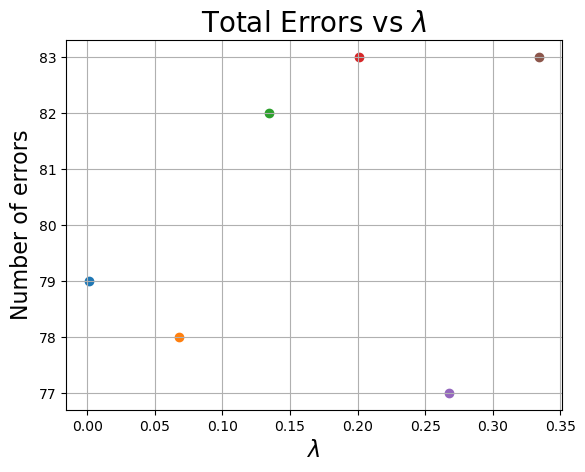

In [21]:
# Initial parameter vectors w and h are created.
w_init = np.ones((1, 197))/np.shape(np.ones((1,197)))[1]
h_init = np.array([[0],[0],[0],[0],[1],[0],[0],[0],[0]])

# Error and correct classification counters.
errors_class1 = 0
errors_class0 = 0
total_errors = 0
class1_correct = 0
class0_correct = 0

# Maximum allowed iterations.
maxIter = 400000

# Lambda values
val = 10
lambdas = []
for i in range(0, 6):
    lambdas.append((0.0667*i + 0.001))

# Evaluate which lambda value is better.
for l in lambdas:

    print(f'\nlambda: {l}')
    w_opt, h_opt = find_params(w_init, h_init, l, maxIter)
    y_hat = output(w_opt.T, h_opt)
    
    for i in range(total_data):
        if i < 100:
            if float(y_hat[i]) >= 0.5:
                class1_correct += 1
            else:
                errors_class1 += 1
        elif i >= 100:
            if float(y_hat[i]) < 0.5:
                class0_correct += 1
            else:
                errors_class0 += 1

    total_errors = errors_class1 + errors_class0

    # Print the number of errors the classifier made for each lambda.
    print(f'class1_errors: {errors_class1}')
    print(f'class0_errors: {errors_class0}\n')

    # Plot the error for the current iteration against its respective lambda value.
    plt.scatter(l, total_errors)
    plt.grid(linestyle='-')
    plt.title('Total Errors vs $\lambda$', fontsize=20)
    plt.xlabel('$\lambda$', fontsize=16)
    plt.ylabel('Number of errors', fontsize=16)

    # Reset counters to plot with the next lambda.
    errors_class1 = 0
    errors_class0 = 0
    total_errors = 0
    class1_correct = 0
    class0_correct = 0


### d) Analysis

- We indicate how many times each class was misclassified/classified correctly.
- We plot the resulting filter, i.e., the 3 × 3 filter constructed with h.
- We show some images that are correctly classified for both digits (2 and 9) after passing through this filter.
- Using the `imagesc` function, we plot the absolute value of the weights in $w$ as a 14×14 image consistent with the images of the digits.


In [22]:
# Chosen lambda
# l_opt = 6.4048
l_opt = 0.2678

# Initial parameter vectors w and h are created.
w_init = np.ones((1, 197))/np.shape(np.ones((1,197)))[1]
h_init = np.array([[0],[0],[0],[0],[1],[0],[0],[0],[0]])

maxIter = 400000
errors_class1 = 0
errors_class0 = 0
total_errors = 0
class1_correct = 0
class0_correct = 0

# Lists to store indices of images that are misclassified and correctly classified.
index_error1 = []
index_error0 = []
index_correct1 = []
index_correct0 = []

w_opt, h_opt = find_params(w_init, h_init, l_opt, maxIter)
rows = np.shape(m)[0]
cols = np.shape(m)[1]
y_hat = output(w_opt.T, h_opt)

for i in range(total_data):
    if i < 100:
        if float(y_hat[i]) >= 0.5:
            class1_correct += 1
            index_correct1.append(i)
        else:
            errors_class1 += 1
            index_error1.append(i)
    elif i >= 100:
        if float(y_hat[i]) < 0.5:
            class0_correct += 1
            index_correct0.append(i)
        else:
            errors_class0 += 1
            index_error0.append(i)

# Print the number of errors the classifier made.
print(f'class1_errors: {errors_class1}')
print(f'class0_errors: {errors_class0}\n')
total_errors = errors_class1 + errors_class0
error_percentage = total_errors/200

# Print the number of correct classifications the classifier made.
correct = class1_correct + class0_correct
correct_percentage = correct/200
print(f'\nPercentage of correct classification: {np.round(correct_percentage, 4)*100}%\n')

# Other data
print(f'Errors of class 1 classification: {errors_class1}')
print(f'Errors of class 0 classification: {errors_class0}')
print(f'Total number of errors: {total_errors}')
print(f'Error percentage: {np.round(error_percentage, 4)*100}% \n')

# Create confusion matrix and print it as a dataframe.
confusion = np.array([[class1_correct, errors_class1], [errors_class0, class0_correct]])
df = pd.DataFrame(confusion, columns=['Class 1', 'Class 0'], index=['Class 1', 'Class 0'])

print(f'Confusion Matrix: \n {df} \n')
print(f'Error Percentage Class 1: {errors_class1}/100 = {np.round(errors_class1/100, 4)*100}%\n')
print(f'Error Percentage Class 0: {errors_class0}/100 = {np.round(errors_class0/100, 4)*100}%\n')


class1_errors: 48
class0_errors: 29


Percentage of correct classification: 61.5%

Errors of class 1 classification: 48
Errors of class 0 classification: 29
Total number of errors: 77
Error percentage: 38.5% 

Confusion Matrix: 
          Class 1  Class 0
Class 1       52       48
Class 0       29       71 

Error Percentage Class 1: 48/100 = 48.0%

Error Percentage Class 0: 29/100 = 28.999999999999996%



h_opt = [ 1.95154180e-05  8.72045663e-05  5.55795694e-05  1.07536837e-04
 -6.82376363e-04  8.93092622e-05  5.16294797e-05  7.06226634e-05
  4.93917838e-05]


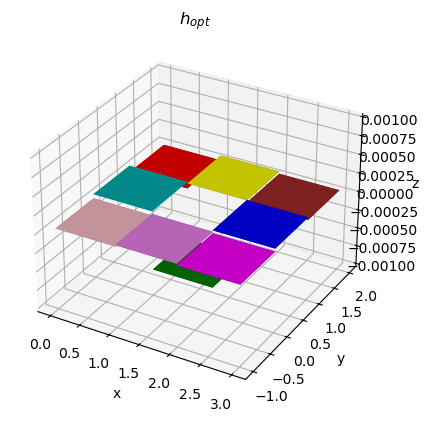

In [23]:
print(f'h_opt = {h_opt}')
h_opt_graph = [x for x in h_opt]

# The number of elements in this list is the number of bars displayed.
# Each element in the list corresponds to the position within the graph (in its respective coordinate).
x3 = [0, 1, 2, 0, 1, 2, 0, 1, 2]
y3 = [1, 1, 1, 0, 0, 0, -1, -1, -1]
z3 = [float(h_opt_graph[0]), float(h_opt_graph[1]), float(h_opt_graph[2]), float(h_opt_graph[3]), float(h_opt_graph[4]), float(h_opt_graph[5]), float(h_opt_graph[6]), float(h_opt_graph[7]), float(h_opt_graph[8])]

# How much space each bar occupies
dx = np.ones(9)
dy = np.ones(9)
dz = np.zeros(9)

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

colors = ['red', 'yellow', 'brown', 'cyan', 'green', 'blue', 'pink', 'violet', 'magenta']
ax1.bar3d(x3, y3, z3, dx, dy, dz, color=colors)
ax1.set_xlabel('x')    
ax1.set_ylabel('y')    
ax1.set_zlabel('z')
ax1.set_zlim([-10**-3, 10**-3])   
ax1.set_title('$h_{opt}$')

plt.show()


[0, 1, 5, 7, 8]


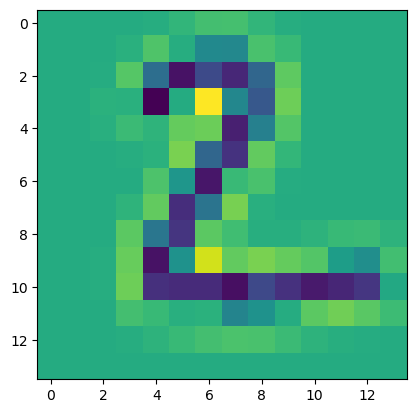

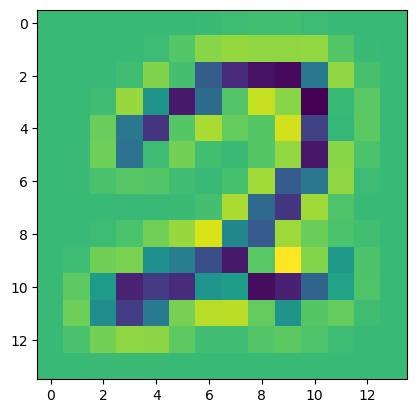

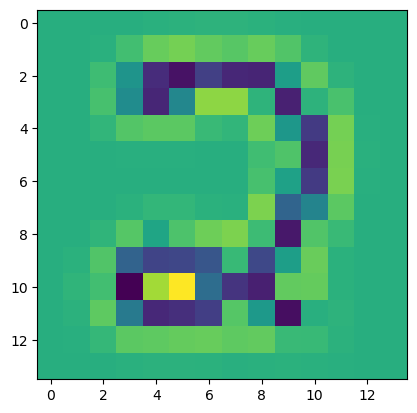

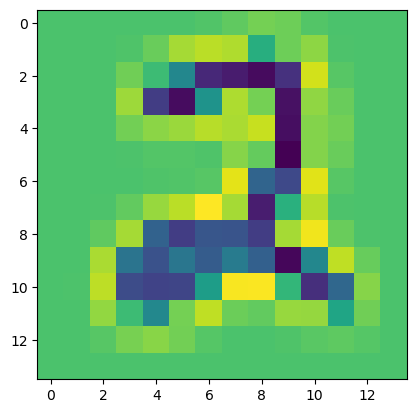

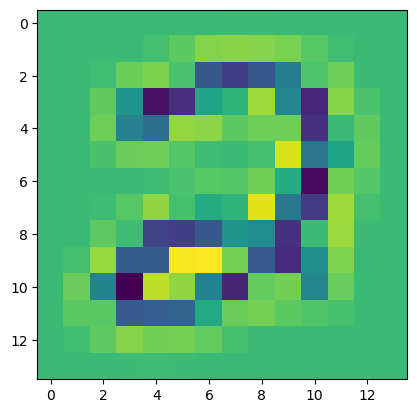

In [24]:
print(index_correct1[:5])
k = np.array([[float(h_opt[0]), float(h_opt[1]), float(h_opt[2])], [float(h_opt[3]), float(h_opt[4]), float(h_opt[5])], [float(h_opt[6]), float(h_opt[7]), float(h_opt[8])]])
for indice in index_correct1[:5]:
    filtered = ndimage.convolve(digits[indice], k)
    plt.figure()# We now show some digits that were correctly classified, filtered with h_opt
    plt.imshow(filtered)

[100, 102, 103, 106, 108]


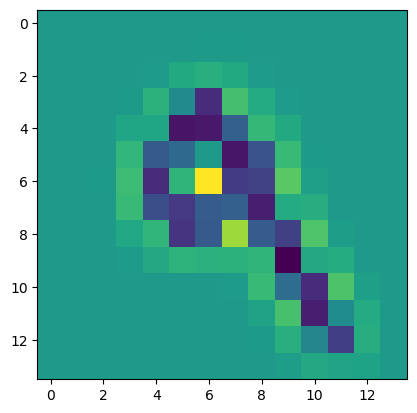

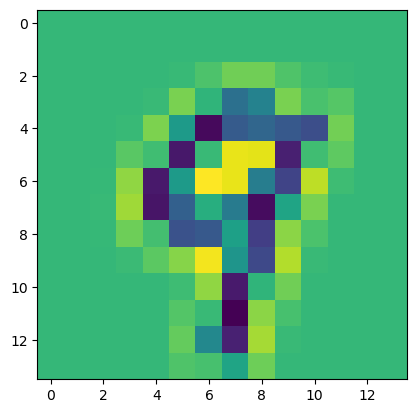

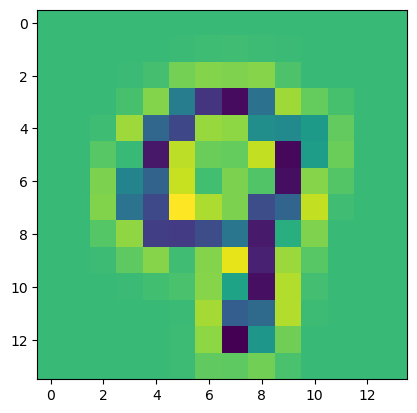

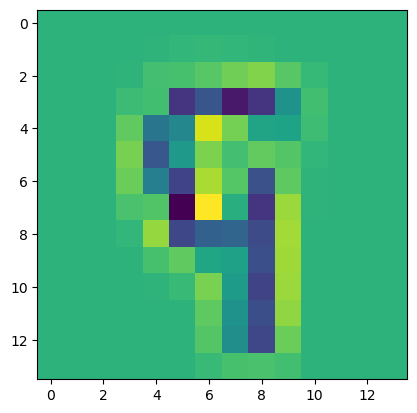

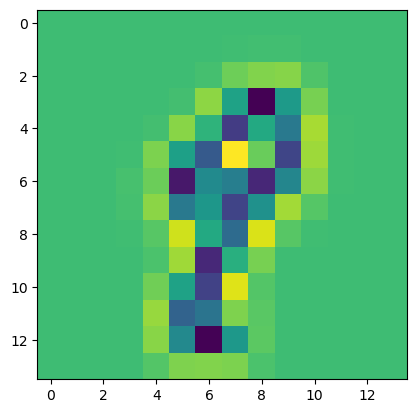

In [25]:
# Some other digits that were correctly classified, filtered with h_opt
print(index_correct0[:5])
k = np.array([[float(h_opt[0]), float(h_opt[1]), float(h_opt[2])], [float(h_opt[3]), float(h_opt[4]), float(h_opt[5])], [float(h_opt[6]), float(h_opt[7]), float(h_opt[8])]])
for indice in index_correct0[:5]:
    filtered = ndimage.convolve(digits[indice], k)
    plt.figure()
    plt.imshow(filtered)

### Based on these previous images, it can be said that the type of operation this filter performs is detection of bottom-right edges.

[2, 3, 4, 6, 11, 13, 16, 21, 22, 23, 24, 28, 32, 33, 35, 36, 37, 38, 39, 41, 45, 46, 47, 48, 50, 51, 53, 56, 58, 59, 63, 64, 66, 67, 68, 70, 71, 73, 74, 78, 81, 89, 90, 91, 93, 94, 95, 99]


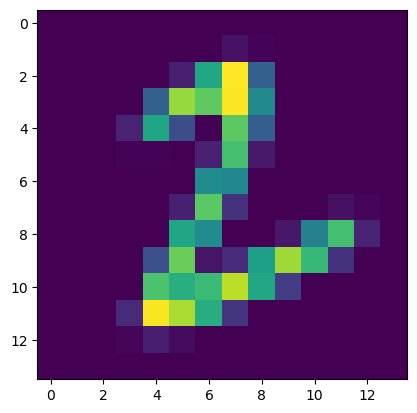

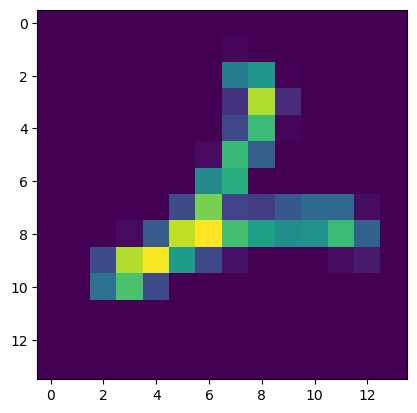

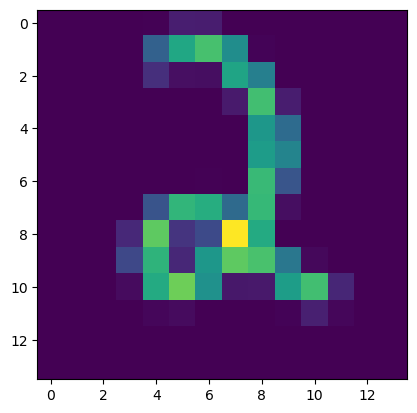

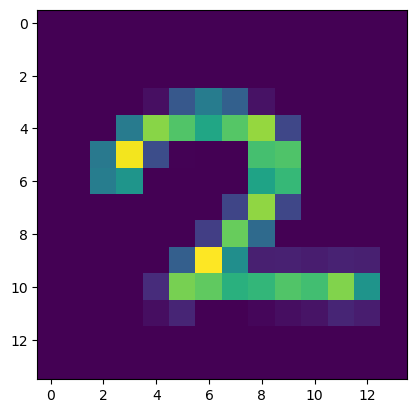

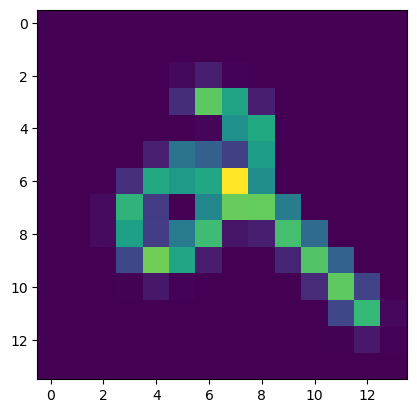

In [26]:
# Some digits for which the algorithm incorrectly classified class 10 (2 digit)
print(index_error1)
for indice in index_error1[:5]:
    plt.figure()
    plt.imshow(digits[indice])

[101, 104, 105, 107, 110, 118, 121, 122, 123, 124, 126, 127, 129, 130, 133, 134, 137, 138, 146, 154, 160, 163, 167, 170, 171, 172, 173, 180, 186]


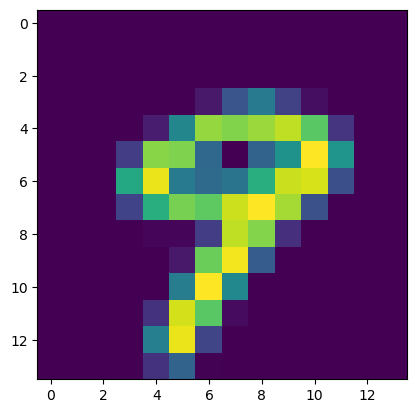

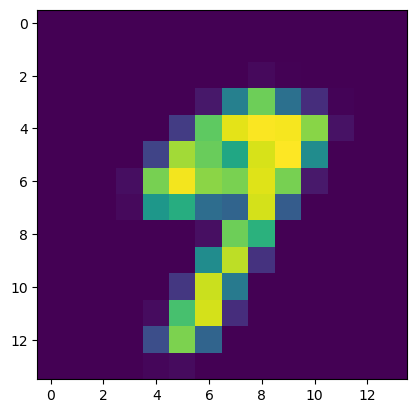

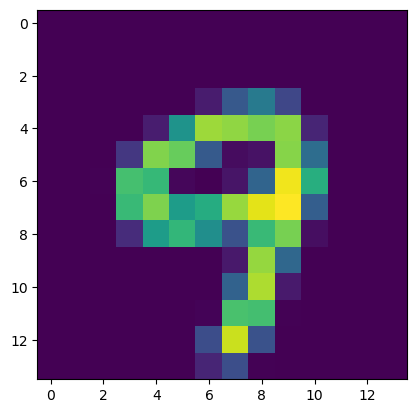

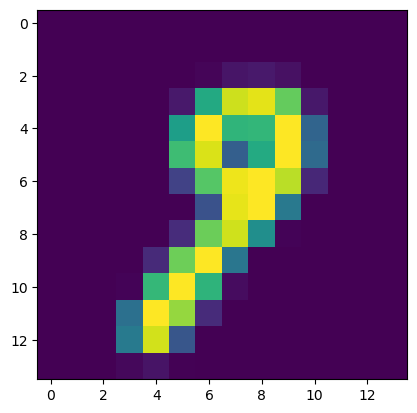

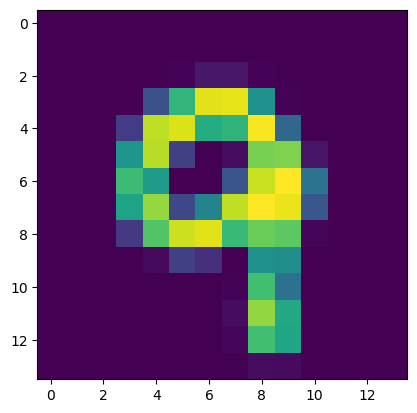

In [27]:
# Some digits for which the algorithm incorrectly classified class 0 (9 digit)
print(index_error0)
for indice in index_error0[:5]:
    plt.figure()
    plt.imshow(digits[indice])

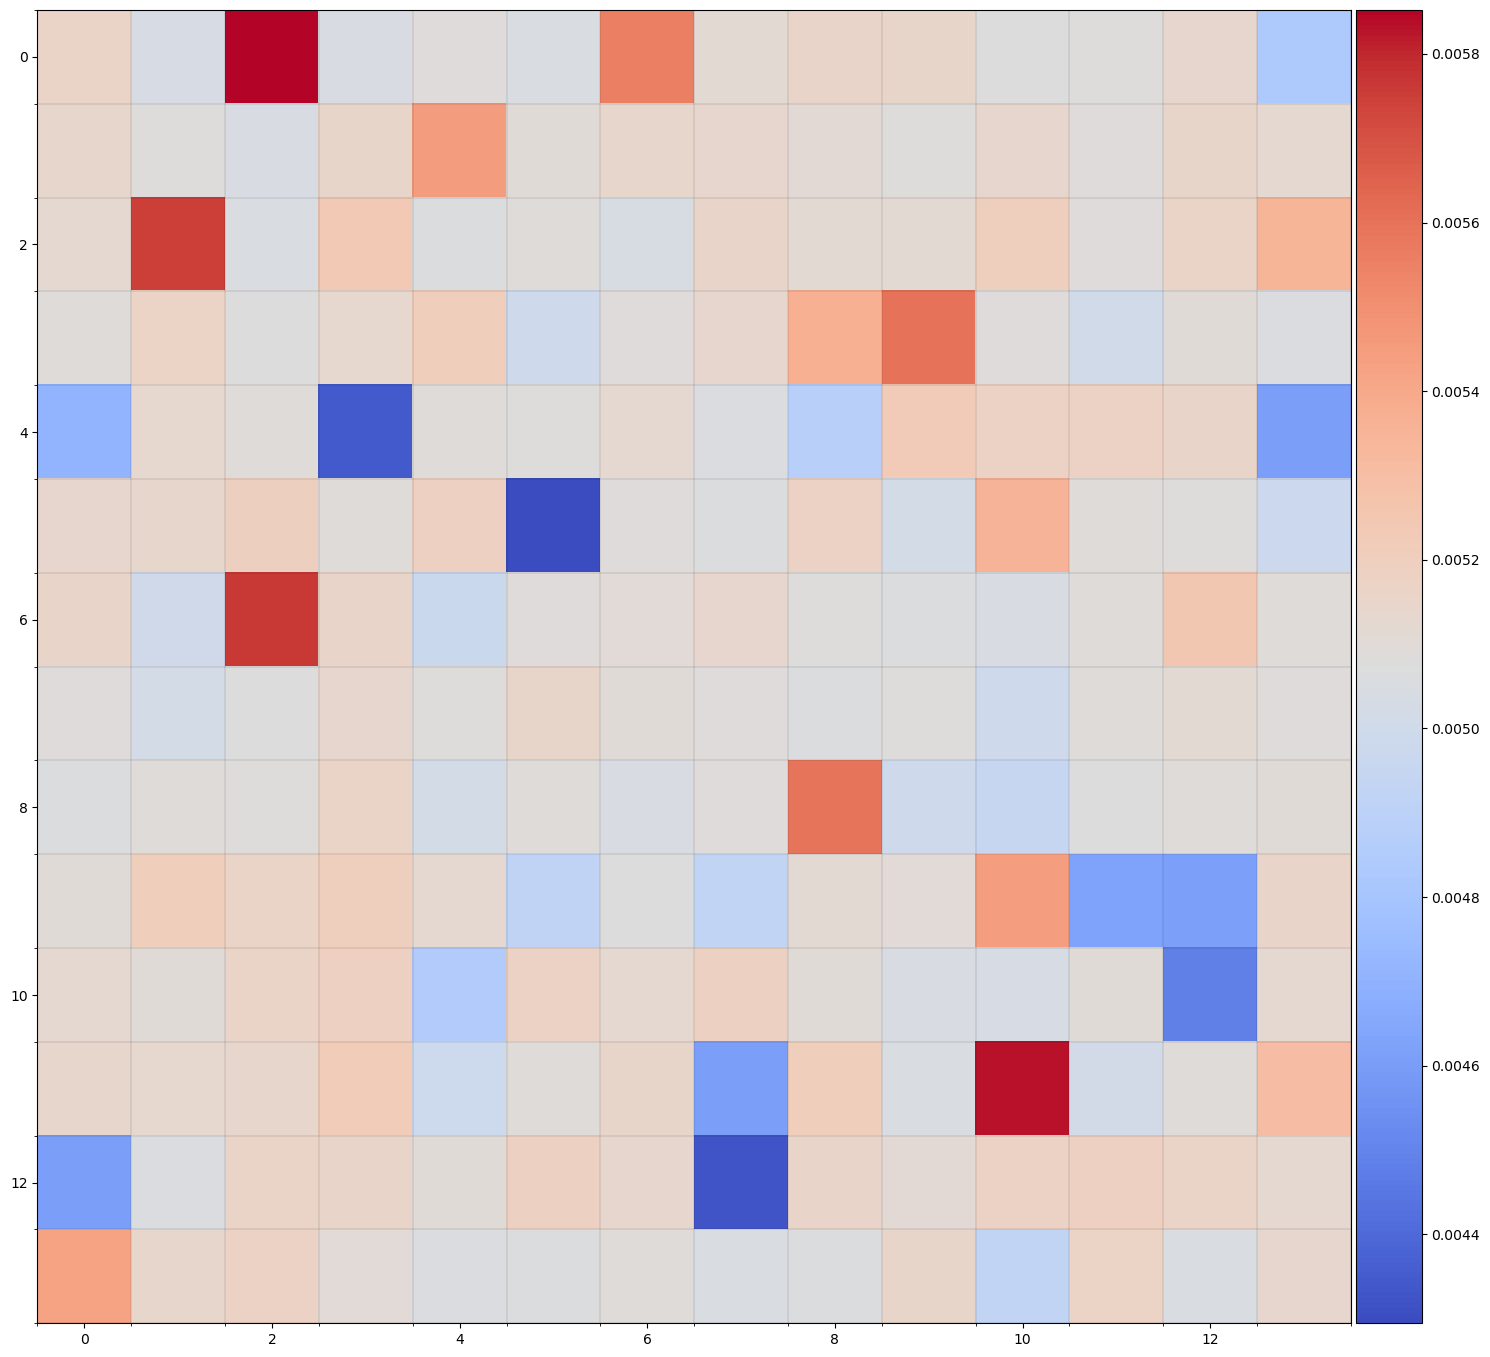

In [28]:
w = np.reshape(w_opt[:-1], (14,14))
fig  = imagesc.plot(np.abs(w))

According to the previous image, the regions where the neural network mainly focuses on for classification are near the center, although the most important ones are located at the bottom of the image and the upper left corner.
